In [1]:
import pandas as pd
import numpy as np
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import AveragePooling2D, MaxPooling2D
import keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_img_and_preprocess(path, shape=None):
  img = load_img(path, target_size=shape)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

content_img = load_img_and_preprocess('messi.jpg')
style_img = load_img_and_preprocess('style.jpg',content_img.shape[1:3])

In [0]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [4]:
base_model_content = VGG16(weights='imagenet',include_top=False, input_shape=shape)
new_model_content  = Sequential()
for layer in base_model_content.layers:
  if layer.__class__ == MaxPooling2D:
      new_model_content.add(AveragePooling2D())
  else:
      new_model_content.add(layer)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 16s 0us/step


In [0]:
def content_loss(content_image, generated_image):
    return K.sum(K.square(content_image - generated_image))

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features)) / x.get_shape().num_elements()
    return gram

In [0]:
def style_loss(style_image, generated_image):
    S = gram_matrix(style_image)
    G = gram_matrix(generated_image)
    return K.mean(K.square(S - G))

In [0]:
content_model = Model(new_model_content.input, new_model_content.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

In [0]:
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in new_model_content.layers \
  if layer.name.endswith('conv1')
]

style_model = Model(new_model_content.input, symbolic_conv_outputs)

style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_weights = [0.2,0.4,0.3,0.5,0.2]

In [0]:
loss = K.mean(K.square(content_model.output - content_target))

In [0]:
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  loss += w * style_loss(symbolic[0], actual[0])

In [0]:
gradients = K.gradients(loss, new_model_content.input)
get_loss_and_grads = K.function(inputs=[new_model_content.input],outputs=[loss] + gradients)

In [0]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

In [0]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [0]:
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


iter=0, loss=3583.236083984375
iter=1, loss=468.86083984375
iter=2, loss=276.0552673339844
iter=3, loss=207.6927947998047
iter=4, loss=176.30140686035156
iter=5, loss=154.4429168701172
iter=6, loss=137.3258056640625
iter=7, loss=124.12451171875
iter=8, loss=115.35025787353516
iter=9, loss=107.97220611572266
iter=10, loss=102.43436431884766
iter=11, loss=97.7386474609375
iter=12, loss=93.94831085205078
iter=13, loss=91.50279235839844
iter=14, loss=89.1427993774414
iter=15, loss=87.34912109375
iter=16, loss=85.5415267944336
iter=17, loss=83.78157043457031
iter=18, loss=82.50774383544922
iter=19, loss=81.38797760009766
iter=20, loss=80.36540985107422
iter=21, loss=79.28024291992188
iter=22, loss=78.36314392089844
iter=23, loss=77.49127197265625
iter=24, loss=76.68870544433594
iter=25, loss=75.76195526123047
iter=26, loss=74.85549926757812
iter=27, loss=74.15106964111328
iter=28, loss=73.47233581542969
iter=29, loss=72.65535736083984
iter=30, loss=72.0771484375
iter=31, loss=71.18268585205

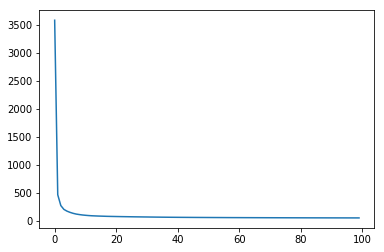

In [18]:
from datetime import datetime
final_img = minimize(get_loss_and_grads_wrapper, 100, batch_shape)

In [0]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

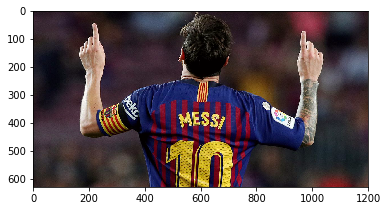

In [20]:
newimg = content_img.reshape(*batch_shape)
messi_img = unpreprocess(newimg)
plt.imshow(scale_img(messi_img[0]))
plt.show()

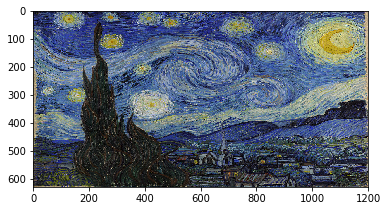

In [21]:
newimg = style_img.reshape(*batch_shape)
messi_img = unpreprocess(newimg)
plt.imshow(scale_img(messi_img[0]))
plt.show()

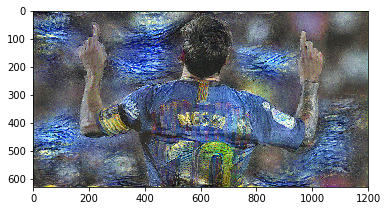

In [22]:
plt.imshow(scale_img(final_img))
plt.show()